# SLP (NMSE)

This notebook computes the normalized mean square error of atmospheric surface pressure.
It is compared to ERA5 observations, as well as the CESM2 large ensemble and CMIP6 model output.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from nmse_utils import nmse
from averaging_utils import seasonal_climatology_weighted

## Parameters

These variables are set in `config.yml`

In [2]:
CESM_output_dir = ""
case_name = ""
start_date = ""
end_date = ""
base_case_output_dir = None
ts_dir = None
base_case_name = None
base_start_date = None
base_end_date = None
obs_data_dir = ""
validation_path = ""
regridded_output = False
base_regridded_output = None

In [3]:
# Parameters
case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.238"
base_case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0045-01-01"
base_start_date = "0001-01-01"
base_end_date = "0081-01-01"
obs_data_dir = (
    "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data"
)
ts_dir = None
lc_kwargs = {"threads_per_worker": 1}
serial = False
regridded_output = False
base_regridded_output = False
validation_path = (
    "atm/analysis_datasets/fv0.9x1.25/seasonal_climatology/nmse_validation/PSL/"
)
subset_kwargs = {}
product = "/glade/work/tking/cupid_project/other_cupids/234v238/CUPiD/examples/key_metrics/computed_notebooks//atm/Global_PSL_NMSE_compare_obs_lens.ipynb"


In [4]:
# Want some base case parameter defaults to equal control case values
if base_case_name is not None:
    if base_case_output_dir is None:
        base_case_output_dir = CESM_output_dir

    if base_start_date is None:
        base_start_date = start_date

    if base_end_date is None:
        base_end_date = end_date

    if base_regridded_output is None:
        base_regridded_output = regridded_output
if ts_dir is None:
    ts_dir = CESM_output_dir

## Read in the current case

In [5]:
def fix_time_dim(dat):
    """CESM2 output sets time as the end of the averaging interval (e.g. January average is midnight on February 1st);
    This function sets the time dimension to the midpoint of the averaging interval.
    Note that CESM3 output sets time to the midpoint already, so this function should not change CESM3 data."""
    if "time" not in dat.dims:
        return dat
    if "bounds" not in dat.time.attrs:
        return dat
    time_bounds_avg = dat[dat.time.attrs["bounds"]].mean("nbnd")
    time_bounds_avg.attrs = dat.time.attrs
    dat = dat.assign_coords({"time": time_bounds_avg})
    return xr.decode_cf(dat)

In [6]:
if regridded_output:
    file_path = f"{ts_dir}/{case_name}/atm/proc/tseries/regrid"
else:
    file_path = f"{ts_dir}/{case_name}/atm/proc/tseries"
print(file_path)

/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing/b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.238/atm/proc/tseries


In [7]:
if base_case_name is not None:
    if base_regridded_output:
        base_file_path = f"{ts_dir}/{base_case_name}/atm/proc/tseries/regrid"
    else:
        base_file_path = f"{ts_dir}/{base_case_name}/atm/proc/tseries"
    print(base_file_path)

/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing/b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234/atm/proc/tseries


In [8]:
dat = (
    fix_time_dim(xr.open_mfdataset(f"{file_path}/*PSL*.nc", decode_times=False))
    .sel(time=slice(start_date, end_date))
    .PSL
    / 100.0
)

# Ensure all datasets have the same coordinates as the output data
# (Avoid round-off level differences since all data should be on the same grid)
lon = dat.lon.data
lat = dat.lat.data

if base_case_name is not None:
    base_dat = (
        fix_time_dim(
            xr.open_mfdataset(f"{base_file_path}/*PSL*.nc", decode_times=False)
        )
        .sel(time=slice(base_start_date, base_end_date))
        .assign_coords({"lon": lon, "lat": lat})
        .PSL
        / 100.0
    )

In [9]:
# --Compute seasonal and annual means
dat = seasonal_climatology_weighted(dat).load()

if base_case_name is not None:
    base_dat = seasonal_climatology_weighted(base_dat).load()

## Read in validation data and other CMIP models for comparison (precomputed)

In [10]:
# ---ERA5
era5 = xr.open_dataset(
    os.path.join(obs_data_dir, validation_path, "PSL_ERA5.nc")
).assign_coords({"lon": lon, "lat": lat})
era5 = era5 / 100.0  # convert to hPa

# ---CESM2
lens2 = xr.open_dataset(
    os.path.join(obs_data_dir, validation_path, "PSL_LENS2.nc")
).assign_coords({"lon": lon, "lat": lat})
lens2 = lens2 / 100.0  # convert to hPa

# ---CMIP6
modelfiles = sorted(
    glob.glob(f"{os.path.join(obs_data_dir,validation_path)}/CMIP6/*.nc")
)
datcmip6 = [
    xr.open_dataset(ifile).assign_coords({"lon": lon, "lat": lat}).mean("M")
    for ifile in modelfiles
]
datcmip6 = xr.concat(datcmip6, dim="model")
datcmip6 = datcmip6 / 100.0

## Compute the NMSE

In [11]:
nmse_dat = []
nmse_cesm2 = []
nmse_cmip6 = []
if base_case_name is not None:
    nmse_base_dat = []
else:
    nmse_base_dat = {key: None for key in ["AM", "DJF", "MAM", "JJA", "SON"]}
for ivar in era5.data_vars:
    nmse_dat.append(nmse(era5[ivar], dat[ivar]))
    nmse_cesm2.append(nmse(era5[ivar], lens2[ivar]))
    nmse_cmip6.append(nmse(era5[ivar], datcmip6[ivar]))
    if base_case_name is not None:
        nmse_base_dat.append(nmse(era5[ivar], base_dat[ivar]))
nmse_dat = xr.merge(nmse_dat)
nmse_cesm2 = xr.merge(nmse_cesm2)
nmse_cmip6 = xr.merge(nmse_cmip6)
if base_case_name is not None:
    nmse_base_dat = xr.merge(nmse_base_dat)

### Set up the plot panel

In [12]:
def plotnmse(fig, cmip6, cesm2, cesm3, cesm_baseline, x1, x2, y1, y2, titlestr):
    ax = fig.add_axes([x1, y1, x2 - x1, y2 - y1])

    cmip6 = cmip6.sortby(cmip6, ascending=False)
    binedges = np.arange(0, cmip6.size, 1)
    ax.bar(
        binedges,
        cmip6,
        width=1,
        bottom=0,
        edgecolor="black",
        color="gray",
        label="CMIP6",
    )

    ax.plot(cmip6.size + 1, cesm3, "o", color="blue", label="THIS RUN")
    if cesm_baseline is not None:
        ax.plot(cmip6.size + 1, cesm_baseline, "x", color="red", label="BASELINE")

    ax.fill_between(
        np.arange(0, cmip6.size + 3, 1) - 0.5,
        np.arange(0, cmip6.size + 3, 1) * 0 + np.array(cesm2.min()),
        np.arange(0, cmip6.size + 3, 1) * 0 + np.array(cesm2.max()),
        color="salmon",
        alpha=0.5,
        label="LENS2",
    )

    ax.set_xlim(-0.5, cmip6.size + 2 - 0.5)
    ax.set_xticks([])
    ax.set_ylabel("NMSE", fontsize=14)
    ax.set_title(titlestr, fontsize=16)

    ax.legend()

    return ax

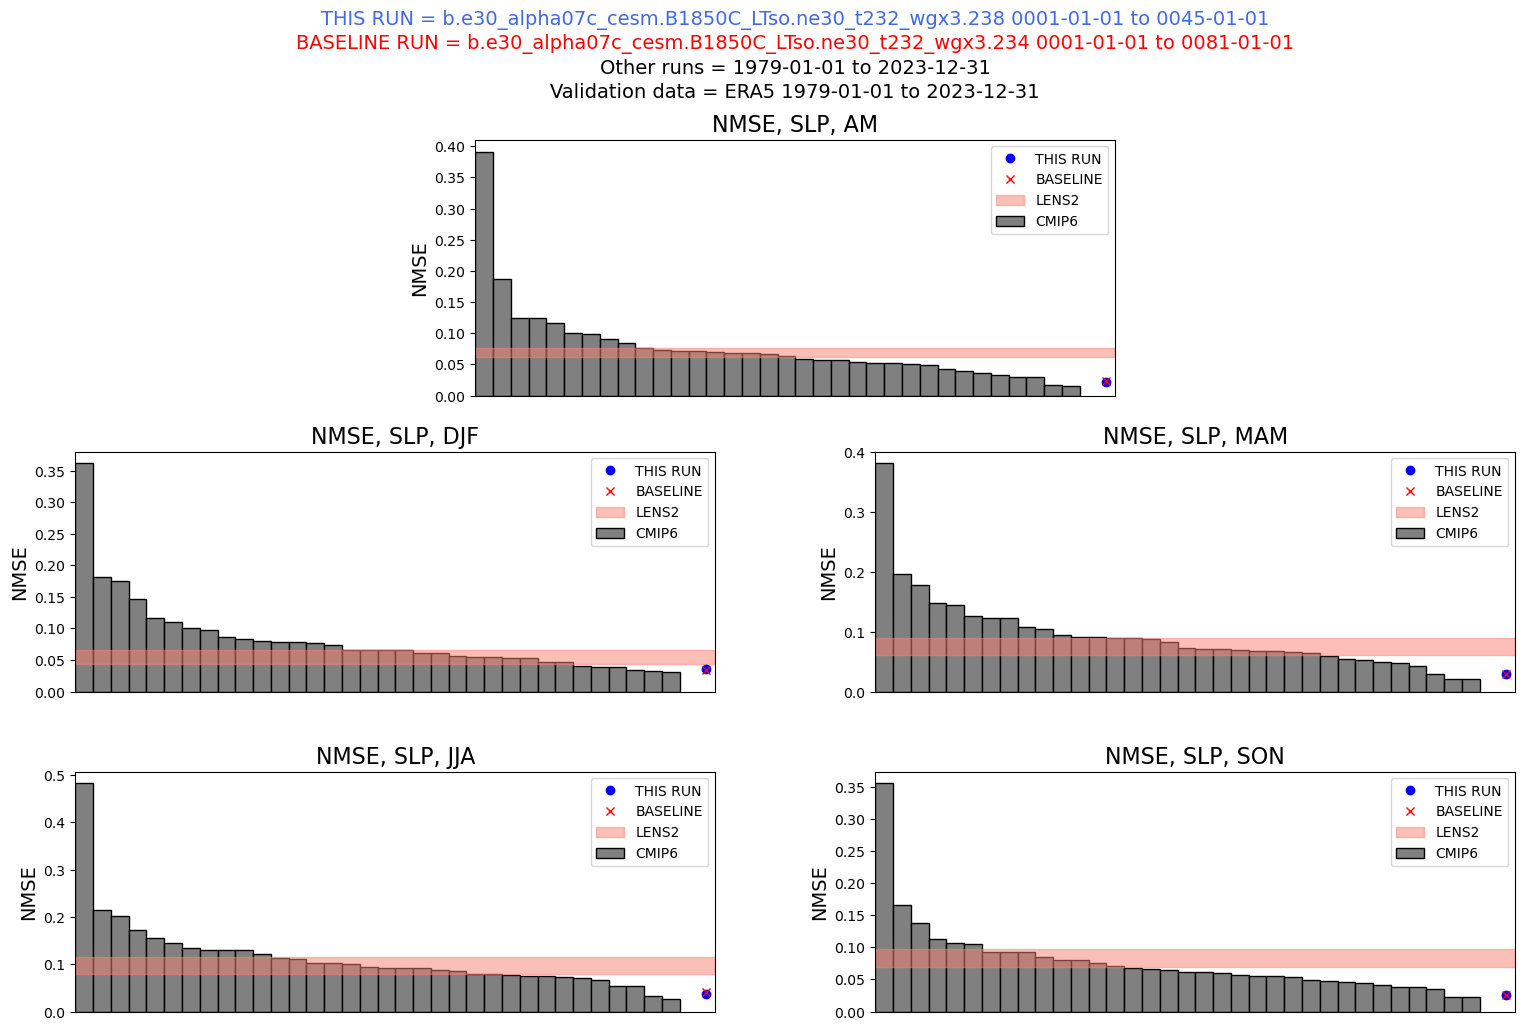

In [13]:
fig = plt.figure(figsize=(16, 16))

vert_coord = 0.99
fig.text(
    0.5,
    vert_coord,
    "THIS RUN = " + case_name + " " + start_date + " to " + end_date,
    ha="center",
    va="center",
    fontsize=14,
    color="royalblue",
)
vert_coord = vert_coord - 0.015
if base_case_name is not None:
    fig.text(
        0.5,
        vert_coord,
        "BASELINE RUN = "
        + base_case_name
        + " "
        + base_start_date
        + " to "
        + base_end_date,
        ha="center",
        va="center",
        fontsize=14,
        color="red",
    )
    vert_coord = vert_coord - 0.015

fig.text(
    0.5,
    vert_coord,
    "Other runs = 1979-01-01 to 2023-12-31",
    ha="center",
    va="center",
    fontsize=14,
)
vert_coord = vert_coord - 0.015

fig.text(
    0.5,
    vert_coord,
    "Validation data = ERA5 1979-01-01 to 2023-12-31",
    ha="center",
    va="center",
    fontsize=14,
)
vert_coord = vert_coord - 0.03

ax = plotnmse(
    fig,
    nmse_cmip6["AM"],
    nmse_cesm2["AM"],
    nmse_dat["AM"],
    nmse_base_dat["AM"],
    0.3,
    0.7,
    vert_coord - 0.16,
    vert_coord,
    "NMSE, SLP, AM",
)
ax = plotnmse(
    fig,
    nmse_cmip6["DJF"],
    nmse_cesm2["DJF"],
    nmse_dat["DJF"],
    nmse_base_dat["DJF"],
    0.05,
    0.45,
    0.57,
    0.72,
    "NMSE, SLP, DJF",
)
ax = plotnmse(
    fig,
    nmse_cmip6["MAM"],
    nmse_cesm2["MAM"],
    nmse_dat["MAM"],
    nmse_base_dat["MAM"],
    0.55,
    0.95,
    0.57,
    0.72,
    "NMSE, SLP, MAM",
)
ax = plotnmse(
    fig,
    nmse_cmip6["JJA"],
    nmse_cesm2["JJA"],
    nmse_dat["JJA"],
    nmse_base_dat["JJA"],
    0.05,
    0.45,
    0.37,
    0.52,
    "NMSE, SLP, JJA",
)
ax = plotnmse(
    fig,
    nmse_cmip6["SON"],
    nmse_cesm2["SON"],
    nmse_dat["SON"],
    nmse_base_dat["SON"],
    0.55,
    0.95,
    0.37,
    0.52,
    "NMSE, SLP, SON",
)